In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

------------------------------------------------

Learning Rate: 0.1, Epoch Count: 50

------------------------------------------------

Fold Train Loss: 0.0336, Fold Val Loss: 0.1619
Fold Train Loss: 0.0312, Fold Val Loss: 0.2396
Fold Train Loss: 0.0328, Fold Val Loss: 0.1100
Fold Train Loss: 0.0306, Fold Val Loss: 0.1524
Fold Train Loss: 0.0325, Fold Val Loss: 0.1425
Avg Train Loss: 0.0321, Avg Val Loss: 0.1613
------------------------------------------------

Learning Rate: 0.1, Epoch Count: 200

------------------------------------------------

Fold Train Loss: 0.0181, Fold Val Loss: 0.2121
Fold Train Loss: 0.0170, Fold Val Loss: 0.3217
Fold Train Loss: 0.0175, Fold Val Loss: 0.1432
Fold Train Loss: 0.0161, Fold Val Loss: 0.1921
Fold Train Loss: 0.0173, Fold Val Loss: 0.1792
Avg Train Loss: 0.0172, Avg Val Loss: 0.2097
------------------------------------------------

Learning Rate: 0.1, Epoch Count: 500

------------------------------------------------

Fold Train Loss: 0.0133, Fo

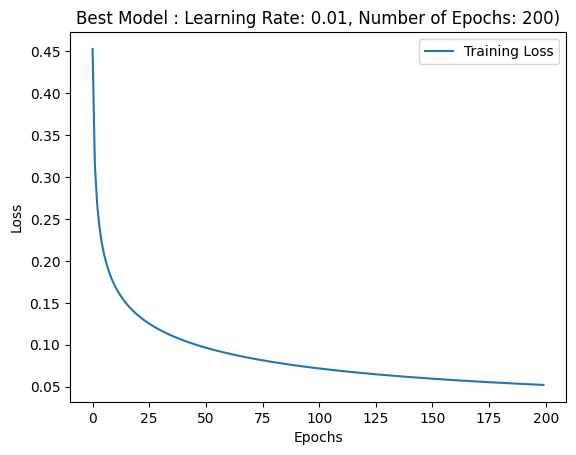

In [6]:
train_df = pd.read_csv("https://raw.githubusercontent.com/bournenadia26/cs131/refs/heads/main/train_midterm.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/bournenadia26/cs131/refs/heads/main/test_midterm.csv")

# from df to numpy arr
X_train = train_df.drop(columns=['label']).to_numpy()
y_train = train_df['label'].to_numpy()
X_test = test_df.drop(columns=['label']).to_numpy()
y_test = test_df['label'].to_numpy()

avg_loss_list = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# values to test
eta_list = [0.1, 0.01, 0.001]
num_of_epochs = [50, 200, 500]

for eta in eta_list:
    for epochs in num_of_epochs:
        val_loss_list = []
        train_loss_list = []

        print("------------------------------------------------")
        print(f"\nLearning Rate: {eta}, Epoch Count: {epochs}\n")
        print("------------------------------------------------\n")

        for train_idx, val_idx in kfold.split(X_train):
            X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
            X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

            w = np.zeros(X_train.shape[1])

            for epoch in range(epochs):
                for i in range(X_train_fold.shape[0]):
                    y_hat = 1 / (1 + np.exp(-np.dot(X_train_fold[i], w)))
                    gradient = (y_hat - y_train_fold[i]) * X_train_fold[i]
                    w -= eta * gradient

            y_train_pred = 1 / (1 + np.exp(-np.dot(X_train_fold, w)))
            y_val_pred = 1 / (1 + np.exp(-np.dot(X_val_fold, w)))
            train_loss = -np.mean(y_train_fold * np.log(y_train_pred + 1e-9) + (1 - y_train_fold) * np.log(1 - y_train_pred + 1e-9))
            val_loss = -np.mean(y_val_fold * np.log(y_val_pred + 1e-9) + (1 - y_val_fold) * np.log(1 - y_val_pred + 1e-9))

            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)

            print(f"Fold Train Loss: {train_loss:.4f}, Fold Val Loss: {val_loss:.4f}")

        avg_train_loss = np.mean(train_loss_list)
        avg_val_loss = np.mean(val_loss_list)
        avg_loss_list.append((eta, epochs, avg_train_loss, avg_val_loss))

        print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

best_val_loss = float('inf')
best_train_loss = 0
best_eta = 0
best_num_of_epochs = 0

print("\n------------------------------------------------")
for eta, epochs, avg_train_loss, avg_val_loss in avg_loss_list:
    print(f"Learning Rate: {eta}, Number of Epochs: {epochs}, Avg Train Loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_train_loss = avg_train_loss
        best_eta = eta
        best_num_of_epochs = epochs

print("------------------------------------------------")
print(f"\nBest Validation Loss: {best_val_loss}, Best Training Loss: {best_train_loss} with Learning Rate: {best_eta}, Number of Epochs: {best_num_of_epochs}\n")
print("------------------------------------------------\n")

# retrain on full set
w = np.zeros(X_train.shape[1])
best_loss_history = []

for epoch in range(best_num_of_epochs):
    epoch_loss = []
    for i in range(X_train.shape[0]):
        y_hat = 1 / (1 + np.exp(-np.dot(X_train[i], w)))
        gradient = (y_hat - y_train[i]) * X_train[i]
        w = w - (best_eta * gradient)

        loss = -np.mean(y_train[i] * np.log(y_hat + 1e-9) + (1 - y_train[i]) * np.log(1 - y_hat + 1e-9))
        epoch_loss.append(loss)

    avg_epoch_loss = np.mean(epoch_loss)
    best_loss_history.append(avg_epoch_loss)

print(f"Final Train Loss: {best_loss_history[-1]}\n")

# test set
y_hat_pred = 1 / (1 + np.exp(-(np.dot(X_test, w))))
y_hat = (y_hat_pred >= 0.5).astype(int)
test_loss = -np.mean(y_test * np.log(y_hat_pred + 1e-9) + (1 - y_test) * np.log(1 - y_hat_pred + 1e-9))

test_accuracy = accuracy_score(y_test, y_hat)
test_f1 = f1_score(y_test, y_hat)

print("------------------------------------------------")
print(f"\nTest Loss: {test_loss}, Accuracy: {test_accuracy}, F1 Score: {test_f1}\n")
print("------------------------------------------------\n")

# plotting
plt.plot(best_loss_history, label='Training Loss')
plt.title(f'Best Model : Learning Rate: {best_eta}, Number of Epochs: {best_num_of_epochs})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()